In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast = 0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [4]:
dataset_path = './dataset'
dataset = datasets.ImageFolder(dataset_path,transform=image_transforms)
len(dataset)

2300

In [31]:
class_names = dataset.classes

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75*len(dataset))
val_size = len(dataset)-train_size
train_size, val_size

(1725, 575)

In [8]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

In [9]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)

In [10]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.3959913].


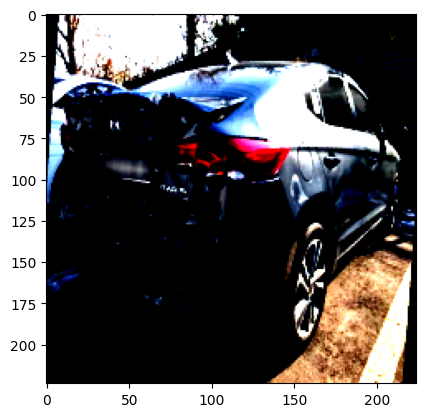

In [11]:
plt.imshow(images[1].permute(1,2,0))

In [12]:
## Model 

In [13]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1,padding=1), # output is 16,224,224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0), # 16,112,112

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0), # 32,56,56

            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size =3, stride =1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0), # 64,28,28

            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )
    def forward(self,x):
        x = self.network(x)
        return x

In [26]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        for batch_num, (images,labels) in enumerate(train_loader):
            images,labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            if(batch_num+1)%10 ==0:
                print(f"Batch: {batch_num+1}, Epoch:{epoch+1}, Loss:{loss.item():0.2f}")

            running_loss = running_loss + loss.item()*images.size(0)
            
        epochs_loss = running_loss/len(train_loader.dataset)
        print(f"Epcoch [{epoch+1}/{epochs}], Avg Loss:{epochs_loss:.4f}")
       

        # validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images,labels in test_loader:
                images,labels = images.to(device), labels.to(device)
                outputs = model(images)
                _,predicted = torch.max(outputs.data,1)
                total = total + labels.size(0)
                correct = correct + (predicted==labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            print(f"** Validation Accuracy: {100*correct/total:.2f}%**")
    end = time.time()
    print("Execution time: ",end-start,"seconds")
    return all_labels,all_predictions

In [35]:
all_labels, all_predictions = train_model(model,criterion,optimizer,epochs=5)

Batch: 10, Epoch:1, Loss:1.10
Batch: 20, Epoch:1, Loss:0.95
Batch: 30, Epoch:1, Loss:1.01
Batch: 40, Epoch:1, Loss:0.76
Batch: 50, Epoch:1, Loss:0.91
Epcoch [1/5], Avg Loss:0.9513
** Validation Accuracy: 54.43%**
Batch: 10, Epoch:2, Loss:1.01
Batch: 20, Epoch:2, Loss:0.81
Batch: 30, Epoch:2, Loss:0.85
Batch: 40, Epoch:2, Loss:0.98
Batch: 50, Epoch:2, Loss:0.83
Epcoch [2/5], Avg Loss:0.8844
** Validation Accuracy: 55.13%**
Batch: 10, Epoch:3, Loss:0.50
Batch: 20, Epoch:3, Loss:0.74
Batch: 30, Epoch:3, Loss:1.00
Batch: 40, Epoch:3, Loss:1.09
Batch: 50, Epoch:3, Loss:0.78
Epcoch [3/5], Avg Loss:0.8400
** Validation Accuracy: 58.61%**
Batch: 10, Epoch:4, Loss:0.88
Batch: 20, Epoch:4, Loss:0.97
Batch: 30, Epoch:4, Loss:0.89
Batch: 40, Epoch:4, Loss:0.85
Batch: 50, Epoch:4, Loss:0.59
Epcoch [4/5], Avg Loss:0.7971
** Validation Accuracy: 59.13%**
Batch: 10, Epoch:5, Loss:0.70
Batch: 20, Epoch:5, Loss:0.55
Batch: 30, Epoch:5, Loss:0.97
Batch: 40, Epoch:5, Loss:0.89
Batch: 50, Epoch:5, Loss:0.6

In [ ]:
# regularisation
class CarClassifierCNNwithRegularisation(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1,padding=1), # output is 16,224,224
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0), # 16,112,112

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0), # 32,56,56

            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size =3, stride =1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0), # 64,28,28

            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)
        )
    def forward(self,x):
        x = self.network(x)
        return x

In [38]:
model = CarClassifierCNNwithRegularisation(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
all_labels, all_predictions = train_model(model,criterion,optimizer,epochs=10)

Batch: 10, Epoch:1, Loss:17.31
Batch: 20, Epoch:1, Loss:6.73
Batch: 30, Epoch:1, Loss:3.82
Batch: 40, Epoch:1, Loss:2.96
Batch: 50, Epoch:1, Loss:2.22
Epcoch [1/10], Avg Loss:7.8678
** Validation Accuracy: 43.13%**
Batch: 10, Epoch:2, Loss:1.42
Batch: 20, Epoch:2, Loss:1.48
Batch: 30, Epoch:2, Loss:1.46
Batch: 40, Epoch:2, Loss:1.51
Batch: 50, Epoch:2, Loss:1.31
Epcoch [2/10], Avg Loss:1.3962
** Validation Accuracy: 48.35%**
Batch: 10, Epoch:3, Loss:1.44
Batch: 20, Epoch:3, Loss:1.30
Batch: 30, Epoch:3, Loss:1.48
Batch: 40, Epoch:3, Loss:1.44
Batch: 50, Epoch:3, Loss:1.13
Epcoch [3/10], Avg Loss:1.2211
** Validation Accuracy: 50.78%**
Batch: 10, Epoch:4, Loss:1.11
Batch: 20, Epoch:4, Loss:0.82
Batch: 30, Epoch:4, Loss:1.28
Batch: 40, Epoch:4, Loss:1.14
Batch: 50, Epoch:4, Loss:1.20
Epcoch [4/10], Avg Loss:1.1325
** Validation Accuracy: 49.57%**
Batch: 10, Epoch:5, Loss:0.99
Batch: 20, Epoch:5, Loss:1.11
Batch: 30, Epoch:5, Loss:0.98
Batch: 40, Epoch:5, Loss:1.06
Batch: 50, Epoch:5, Los

In [ ]:
# Transfer Learning to improve accuracy

In [16]:
# EfficientNet

class CarClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features,num_classes)
        )
    def forward(self,x):
        x = self.model(x)
        return x

In [17]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model,criterion, optimizer, epochs = 10)

Batch: 10, Epoch:1, Loss:1.67
Batch: 20, Epoch:1, Loss:1.47
Batch: 30, Epoch:1, Loss:1.50
Batch: 40, Epoch:1, Loss:1.34
Batch: 50, Epoch:1, Loss:1.39
Epcoch [1/10], Avg Loss:1.4919
** Validation Accuracy: 63.65%**
Batch: 10, Epoch:2, Loss:1.03
Batch: 20, Epoch:2, Loss:1.22
Batch: 30, Epoch:2, Loss:1.01
Batch: 40, Epoch:2, Loss:1.13
Batch: 50, Epoch:2, Loss:0.94
Epcoch [2/10], Avg Loss:1.1428
** Validation Accuracy: 66.43%**
Batch: 10, Epoch:3, Loss:1.07
Batch: 20, Epoch:3, Loss:0.98
Batch: 30, Epoch:3, Loss:1.05
Batch: 40, Epoch:3, Loss:1.10
Batch: 50, Epoch:3, Loss:0.98
Epcoch [3/10], Avg Loss:1.0130
** Validation Accuracy: 65.39%**
Batch: 10, Epoch:4, Loss:1.04
Batch: 20, Epoch:4, Loss:1.09
Batch: 30, Epoch:4, Loss:0.81
Batch: 40, Epoch:4, Loss:0.98
Batch: 50, Epoch:4, Loss:1.05
Epcoch [4/10], Avg Loss:0.9537
** Validation Accuracy: 68.00%**
Batch: 10, Epoch:5, Loss:0.84
Batch: 20, Epoch:5, Loss:0.68
Batch: 30, Epoch:5, Loss:0.85
Batch: 40, Epoch:5, Loss:0.92
Batch: 50, Epoch:5, Loss

([0,
  3,
  5,
  5,
  4,
  0,
  4,
  4,
  0,
  0,
  2,
  3,
  0,
  3,
  5,
  2,
  3,
  5,
  2,
  0,
  0,
  0,
  1,
  0,
  0,
  2,
  4,
  5,
  0,
  2,
  0,
  0,
  0,
  1,
  4,
  1,
  5,
  2,
  2,
  0,
  1,
  0,
  0,
  1,
  4,
  0,
  4,
  1,
  2,
  0,
  1,
  0,
  0,
  2,
  5,
  3,
  2,
  0,
  1,
  1,
  0,
  1,
  5,
  3,
  4,
  2,
  0,
  5,
  3,
  2,
  2,
  0,
  3,
  5,
  1,
  0,
  1,
  5,
  2,
  0,
  3,
  2,
  3,
  4,
  0,
  3,
  0,
  2,
  0,
  3,
  0,
  1,
  1,
  2,
  3,
  2,
  4,
  0,
  2,
  1,
  3,
  3,
  3,
  2,
  1,
  0,
  0,
  0,
  1,
  4,
  2,
  0,
  5,
  0,
  5,
  2,
  1,
  2,
  1,
  0,
  0,
  3,
  4,
  2,
  1,
  1,
  1,
  0,
  4,
  5,
  3,
  4,
  2,
  2,
  2,
  4,
  4,
  2,
  2,
  2,
  1,
  2,
  3,
  3,
  3,
  1,
  3,
  2,
  5,
  2,
  3,
  0,
  2,
  1,
  0,
  5,
  1,
  0,
  0,
  5,
  0,
  5,
  5,
  4,
  5,
  2,
  2,
  1,
  4,
  0,
  2,
  0,
  0,
  2,
  0,
  0,
  0,
  3,
  5,
  2,
  2,
  1,
  1,
  3,
  2,
  4,
  4,
  2,
  0,
  1,
  1,
  1,
  3,
  2,
  2,
  2,
  4,
  4,
  0,
  1,


In [17]:
## ResNet

class CarClassifierCNNResNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [21]:
model = CarClassifierCNNResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model,criterion, optimizer, epochs = 10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Aayush Garg/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:25<00:00, 4.09MB/s]


Batch: 10, Epoch:1, Loss:1.26
Batch: 20, Epoch:1, Loss:0.74
Batch: 30, Epoch:1, Loss:0.80
Batch: 40, Epoch:1, Loss:0.49
Batch: 50, Epoch:1, Loss:0.58
Epcoch [1/10], Avg Loss:0.9146
** Validation Accuracy: 69.22%**
Batch: 10, Epoch:2, Loss:0.46
Batch: 20, Epoch:2, Loss:0.64
Batch: 30, Epoch:2, Loss:0.27
Batch: 40, Epoch:2, Loss:0.60
Batch: 50, Epoch:2, Loss:0.75
Epcoch [2/10], Avg Loss:0.5087
** Validation Accuracy: 76.52%**
Batch: 10, Epoch:3, Loss:0.46
Batch: 20, Epoch:3, Loss:0.33
Batch: 30, Epoch:3, Loss:0.31
Batch: 40, Epoch:3, Loss:0.51
Batch: 50, Epoch:3, Loss:0.42
Epcoch [3/10], Avg Loss:0.3333
** Validation Accuracy: 79.48%**
Batch: 10, Epoch:4, Loss:0.18
Batch: 20, Epoch:4, Loss:0.39
Batch: 30, Epoch:4, Loss:0.36
Batch: 40, Epoch:4, Loss:0.24
Batch: 50, Epoch:4, Loss:0.43
Epcoch [4/10], Avg Loss:0.2936
** Validation Accuracy: 77.74%**
Batch: 10, Epoch:5, Loss:0.15
Batch: 20, Epoch:5, Loss:0.18
Batch: 30, Epoch:5, Loss:0.20
Batch: 40, Epoch:5, Loss:0.10
Batch: 50, Epoch:5, Loss

([3,
  2,
  2,
  3,
  2,
  1,
  2,
  2,
  2,
  2,
  3,
  0,
  5,
  4,
  3,
  0,
  3,
  3,
  4,
  3,
  2,
  4,
  2,
  5,
  0,
  1,
  0,
  0,
  2,
  2,
  5,
  3,
  2,
  4,
  0,
  5,
  1,
  3,
  1,
  5,
  2,
  1,
  1,
  0,
  2,
  2,
  2,
  4,
  5,
  0,
  5,
  1,
  2,
  4,
  3,
  2,
  5,
  3,
  5,
  0,
  0,
  2,
  1,
  0,
  0,
  5,
  1,
  4,
  1,
  1,
  4,
  2,
  5,
  2,
  2,
  4,
  0,
  0,
  4,
  0,
  4,
  1,
  1,
  1,
  2,
  1,
  4,
  5,
  3,
  2,
  0,
  3,
  5,
  2,
  3,
  4,
  2,
  2,
  3,
  2,
  4,
  2,
  3,
  3,
  0,
  2,
  5,
  0,
  5,
  0,
  0,
  2,
  3,
  0,
  1,
  1,
  2,
  2,
  4,
  2,
  4,
  4,
  0,
  4,
  0,
  4,
  2,
  2,
  2,
  5,
  3,
  3,
  3,
  2,
  0,
  2,
  0,
  5,
  1,
  3,
  0,
  1,
  5,
  2,
  4,
  2,
  0,
  1,
  5,
  4,
  0,
  2,
  2,
  4,
  2,
  3,
  2,
  1,
  1,
  2,
  5,
  1,
  0,
  2,
  2,
  1,
  0,
  0,
  5,
  3,
  2,
  0,
  1,
  0,
  2,
  3,
  4,
  4,
  1,
  5,
  1,
  4,
  0,
  3,
  4,
  2,
  0,
  5,
  0,
  3,
  3,
  0,
  1,
  0,
  0,
  0,
  3,
  2,
  0,
  5,


In [18]:
# Hyperparameter Tuning
import optuna

class CarClassifierCNNResNetHyperParameterTuning(nn.Module):
    def __init__(self,num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [26]:
def objective(trial):
    lr = trial.suggest_float('lr',1e-5,1e-2,log=True)
    dropout_rate = trial.suggest_float('dropout_rate',0.2,0.7)

    model = CarClassifierCNNResNetHyperParameterTuning(num_classes = num_classes, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()),lr=lr)

    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for batch_num, (images,labels) in enumerate(train_loader):
            images,labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss = running_loss + loss.item()*images.size(0)
        epoch_loss = running_loss/len(train_loader.dataset)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images,labels = images.to(device), labels.to(device)
                outputs = model(images)
                _,predicted = torch.max(outputs.data,1)
                total = total + labels.size(0)
                correct = correct + (predicted==labels).sum().item()
        accuracy = 100*correct/total
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print("Execution time :",end-start," seconds")
    return accuracy
                

In [27]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=20)

[I 2025-05-24 13:04:33,648] A new study created in memory with name: no-name-df4459ca-86ff-4218-a490-e833f7ff9719
[I 2025-05-24 13:10:27,918] Trial 0 finished with value: 78.43478260869566 and parameters: {'lr': 0.0001267273000853656, 'dropout_rate': 0.49653508180045863}. Best is trial 0 with value: 78.43478260869566.


Execution time : 353.3911533355713  seconds


[I 2025-05-24 13:16:34,944] Trial 1 finished with value: 77.04347826086956 and parameters: {'lr': 0.0006516600717485793, 'dropout_rate': 0.45367284785437956}. Best is trial 0 with value: 78.43478260869566.


Execution time : 366.4469668865204  seconds


[I 2025-05-24 13:22:41,747] Trial 2 finished with value: 76.0 and parameters: {'lr': 0.0017434842223284775, 'dropout_rate': 0.3537028976004507}. Best is trial 0 with value: 78.43478260869566.


Execution time : 366.05983090400696  seconds


[I 2025-05-24 13:29:19,307] Trial 3 finished with value: 76.34782608695652 and parameters: {'lr': 8.049488477235166e-05, 'dropout_rate': 0.3916824361804643}. Best is trial 0 with value: 78.43478260869566.


Execution time : 396.9953441619873  seconds


[I 2025-05-24 13:36:25,357] Trial 4 finished with value: 78.6086956521739 and parameters: {'lr': 0.0005441659948858859, 'dropout_rate': 0.35673352914380074}. Best is trial 4 with value: 78.6086956521739.


Execution time : 425.4555287361145  seconds


[I 2025-05-24 13:43:28,000] Trial 5 finished with value: 77.04347826086956 and parameters: {'lr': 0.0007942287027073265, 'dropout_rate': 0.4115223986528217}. Best is trial 4 with value: 78.6086956521739.


Execution time : 421.9100182056427  seconds


[I 2025-05-24 13:45:45,476] Trial 6 pruned. 
[I 2025-05-24 13:48:21,700] Trial 7 pruned. 
[I 2025-05-24 13:56:50,012] Trial 8 finished with value: 82.08695652173913 and parameters: {'lr': 0.0011391399530298687, 'dropout_rate': 0.5073346972626421}. Best is trial 8 with value: 82.08695652173913.


Execution time : 507.70015573501587  seconds


[I 2025-05-24 13:58:51,539] Trial 9 pruned. 
[I 2025-05-24 14:00:52,525] Trial 10 pruned. 
[I 2025-05-24 14:04:56,767] Trial 11 pruned. 
[I 2025-05-24 14:07:00,228] Trial 12 pruned. 
[I 2025-05-24 14:09:04,767] Trial 13 pruned. 
[I 2025-05-24 14:11:59,699] Trial 14 pruned. 
[I 2025-05-24 14:18:07,967] Trial 15 pruned. 
[I 2025-05-24 14:24:13,712] Trial 16 pruned. 
[I 2025-05-24 14:27:17,578] Trial 17 pruned. 
[I 2025-05-24 14:36:29,122] Trial 18 finished with value: 80.69565217391305 and parameters: {'lr': 0.0002173797943248954, 'dropout_rate': 0.3851944590496007}. Best is trial 8 with value: 82.08695652173913.


Execution time : 550.6619536876678  seconds


[I 2025-05-24 14:39:32,884] Trial 19 pruned. 


In [28]:
study.best_params

{'lr': 0.0011391399530298687, 'dropout_rate': 0.5073346972626421}

In [29]:
best_model = CarClassifierCNNResNetHyperParameterTuning(num_classes = num_classes, dropout_rate=0.5073346972626421).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad, best_model.parameters()),lr=0.0011391399530298687)

all_labels, all_predictions = train_model(best_model, criterion, optimizer, epochs = 10)

Batch: 10, Epoch:1, Loss:1.20
Batch: 20, Epoch:1, Loss:0.72
Batch: 30, Epoch:1, Loss:0.65
Batch: 40, Epoch:1, Loss:0.59
Batch: 50, Epoch:1, Loss:0.61
Epcoch [1/10], Avg Loss:0.8636
** Validation Accuracy: 71.83%**
Batch: 10, Epoch:2, Loss:0.38
Batch: 20, Epoch:2, Loss:0.55
Batch: 30, Epoch:2, Loss:0.44
Batch: 40, Epoch:2, Loss:0.30
Batch: 50, Epoch:2, Loss:0.76
Epcoch [2/10], Avg Loss:0.4772
** Validation Accuracy: 75.13%**
Batch: 10, Epoch:3, Loss:0.32
Batch: 20, Epoch:3, Loss:0.31
Batch: 30, Epoch:3, Loss:0.19
Batch: 40, Epoch:3, Loss:0.36
Batch: 50, Epoch:3, Loss:0.42
Epcoch [3/10], Avg Loss:0.3355
** Validation Accuracy: 76.70%**
Batch: 10, Epoch:4, Loss:0.20
Batch: 20, Epoch:4, Loss:0.09
Batch: 30, Epoch:4, Loss:0.26
Batch: 40, Epoch:4, Loss:0.31
Batch: 50, Epoch:4, Loss:0.27
Epcoch [4/10], Avg Loss:0.2417
** Validation Accuracy: 78.26%**
Batch: 10, Epoch:5, Loss:0.31
Batch: 20, Epoch:5, Loss:0.13
Batch: 30, Epoch:5, Loss:0.04
Batch: 40, Epoch:5, Loss:0.18
Batch: 50, Epoch:5, Loss

In [30]:
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       123
           1       0.81      0.63      0.71        94
           2       0.79      0.98      0.87       131
           3       0.85      0.73      0.78        85
           4       0.72      0.45      0.56        64
           5       0.64      0.90      0.75        78

    accuracy                           0.79       575
   macro avg       0.79      0.76      0.76       575
weighted avg       0.80      0.79      0.78       575



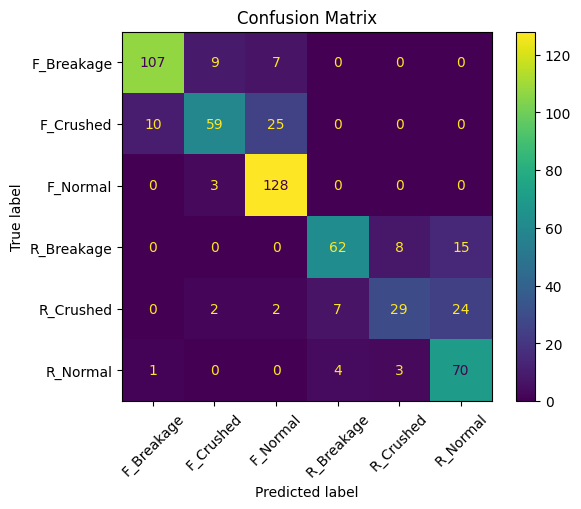

In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(all_labels,all_predictions,labels = np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(xticks_rotation=45 )
plt.title("Confusion Matrix")
plt.show()

In [38]:
torch.save(best_model.state_dict(),'saved_model.pth')